# E-ticaret Platformu Müşteri Yorumlarının Sınıflandırılması (Olumlu/Olumsuz/Nötr Yorum Sınıflandırma)
**1. Gerekli Kütüphanelerin Eklenmesi**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Veri setini yükleyelim ve ınceleyelim
data = pd.read_csv(r"C:\Users\keski\OneDrive\Masaüstü\Slaytlar\4.sinifGuz\YapaySinirAglari\dataset2.csv", delimiter=";")  
data.head()

,Metin,Durum
0,evet anlatıldığı gibi,1
1,Daha öncede almıştım bu cihazdan ense ve sakal...,1
2,Ürün gayet başarılı sakal kesmede başlık sayıs...,1
3,Daha öncede aynısını almıştım çok güzel ve kal...,1
4,Erkek kuaförüyüm ense ve sıfır sakal traşı içi...,1


**2. Veri Keşfi ve Temizleme**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19170 entries, 0 to 19169
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Metin   19170 non-null  object
 1   Durum   19170 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 299.7+ KB
None
Eksik veriler:
 Metin    0
Durum    0
dtype: int64


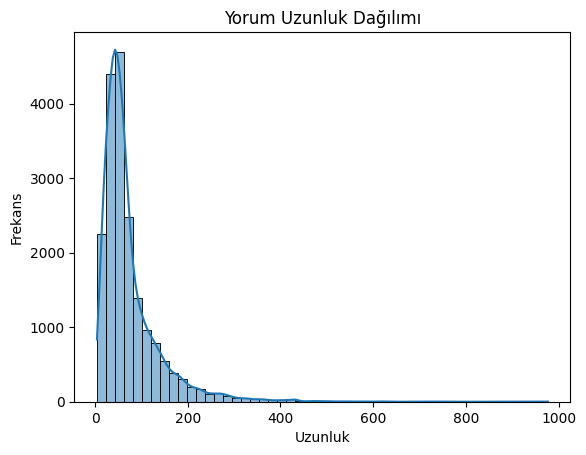

In [6]:
# Veri setinin özeti
print(data.info())

# Eksik verilerin kontrolü
print("Eksik veriler:\n", data.isnull().sum())

# Sütun isimlerini kontrol edelim
data.columns

# Yorumların uzunluk analizi yapılır
data['metin_uzunluk'] = data['Metin'].apply(len)
sns.histplot(data['metin_uzunluk'], bins=50, kde=True)
plt.title("Yorum Uzunluk Dağılımı")
plt.xlabel("Uzunluk")
plt.ylabel("Frekans")
plt.show()

**3. Veri Ön İşleme**

In [22]:
# Özel karakterler ve büyük harf temizleme
data = data[data['Metin'].apply(len) > 10]
def temizle(metin):
    metin = metin.lower()
    metin = metin.replace("\n", " ")
    metin = ''.join(char for char in metin if char.isalnum() or char.isspace())
    return metin

data['Temiz_Metin'] = data['Metin'].apply(temizle)

# Label Encoding (Durum kolonunu sayısal formata çevirme)
label_encoder = LabelEncoder()
data['Durum_Kod'] = label_encoder.fit_transform(data['Durum'])

# Durum kodlarını kategorik forma çevirme (3 sınıf için)
y = to_categorical(data['Durum_Kod'])

# Veri setini öğrenme ve test olarak ayıralım
X = data['Temiz_Metin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=data['Durum_Kod'])

# Metin verisini TF-IDF vektörleştirme
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

**4. Model Geliştirme**

In [25]:
# ANN modeli oluşturalım
model = Sequential([
    Input(shape=(X_train_vec.shape[1],)),  # Input katmanı ile şekli belirleyin
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # Çıkış katmanı, 3 sınıf için
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitelim
history = model.fit(X_train_vec, y_train, epochs=6, batch_size=32, validation_data=(X_test_vec, y_test))

Epoch 1/6
475/475 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.6923 - loss: 0.6644 - val_accuracy: 0.9167 - val_loss: 0.2257
Epoch 2/6
475/475 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9365 - loss: 0.1779 - val_accuracy: 0.9172 - val_loss: 0.2318
Epoch 3/6
475/475 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9618 - loss: 0.1112 - val_accuracy: 0.9178 - val_loss: 0.2528
Epoch 4/6
475/475 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9772 - loss: 0.0694 - val_accuracy: 0.9164 - val_loss: 0.2790
Epoch 5/6
475/475 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9813 - loss: 0.0568 - val_accuracy: 0.9143 - val_loss: 0.3266
Epoch 6/6
475/475 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9878 - loss: 0.0392 - val_accuracy: 0.9143 - val_loss: 0.3439


**5. Performans Değerlendirmesi**

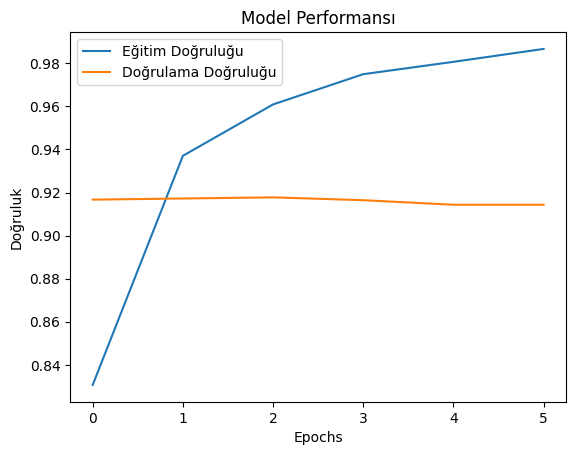

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9129 - loss: 0.3474
Test Doğruluğu: 0.91


In [27]:
# Modelin performansını grafikle gösterelim
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epochs')
plt.ylabel('Doğruluk')
plt.legend()
plt.title('Model Performansı')
plt.show()

# Modeli test edelim
loss, accuracy = model.evaluate(X_test_vec, y_test)
print(f"Test Doğruluğu: {accuracy:.2f}")

**6. Demo**

In [211]:
# Kullanıcıdan bir yorum alıp tahmin yapalım
def yorum_tahmin(yeni_yorum):
    temiz_yeni = temizle(yeni_yorum)
    vektör_yeni = vectorizer.transform([temiz_yeni]).toarray()
    tahmin = model.predict(vektör_yeni)
    sinif = np.argmax(tahmin)
    
    # Sayısal değeri metne dönüştür
    if sinif == 0:
        durum = "Olumsuz"
    elif sinif == 1:
        durum = "Olumlu"
    else:
        durum = "Nötr"

    olasiliklar = tahmin[0]
    
    # Çıktıyı istenilen formatta döndürelim
    return f"""
    Yorum: {yeni_yorum}
    Durum: {durum}
    Olasılıklar: Olumsuz: {olasiliklar[0]*100:.2f}%  Nötr: {olasiliklar[2]*100:.2f}%  Olumlu: {olasiliklar[1]*100:.2f}%
    """

# Kullanıcıdan yorum alalım ve tahmin yapalım
while True:
    yorum = input("Lütfen bir yorum girin (çıkmak için 'exit' yazın): ")
    if yorum.lower() == 'exit':
        print("Çıkılıyor...")
        break
    
    print(yorum_tahmin(yorum))  # Kullanıcının girdiği yorumu tahmin et


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  2 ci siparişim ve önceki aldığım ürün daha kaliteliydi.Şimdi bu ürün resmn sulandırılmış.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

    Yorum: 2 ci siparişim ve önceki aldığım ürün daha kaliteliydi.Şimdi bu ürün resmn sulandırılmış.
    Durum: Olumsuz
    Olasılıklar: Olumsuz: 100.00%  Nötr: 0.00%  Olumlu: 0.00%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  Mükemmelsin bir ürünsün bebeğim 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

    Yorum: Mükemmelsin bir ürünsün bebeğim 
    Durum: Olumsuz
    Olasılıklar: Olumsuz: 60.46%  Nötr: 25.03%  Olumlu: 14.51%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  Özellikle hamilelikte oluşan lekelerim de gozle görülür şekilde azalmalar oldu.Hem de 5 günlük gibi kısa bı sürede.Ben çok memnun kaldım.Almak isteyenler l,aklında soru işareti olanlar gönül rahatlığıyla alabilirler.Hemen emiliyor ve cildi yumuşacık yapıyor.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

    Yorum: Özellikle hamilelikte oluşan lekelerim de gozle görülür şekilde azalmalar oldu.Hem de 5 günlük gibi kısa bı sürede.Ben çok memnun kaldım.Almak isteyenler l,aklında soru işareti olanlar gönül rahatlığıyla alabilirler.Hemen emiliyor ve cildi yumuşacık yapıyor.
    Durum: Olumlu
    Olasılıklar: Olumsuz: 0.00%  Nötr: 0.00%  Olumlu: 100.00%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  Ürünü kullanmaya başladım umarım övüldüğü kadar vardır benim yüzümde herkesin beğendiği ama benim istemediğim çillerim var rengini açarsa süper olur sonuçu istediğim gibi olursa yorumu tekrar güncelleyeceğim 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

    Yorum: Ürünü kullanmaya başladım umarım övüldüğü kadar vardır benim yüzümde herkesin beğendiği ama benim istemediğim çillerim var rengini açarsa süper olur sonuçu istediğim gibi olursa yorumu tekrar güncelleyeceğim 
    Durum: Olumsuz
    Olasılıklar: Olumsuz: 99.80%  Nötr: 0.14%  Olumlu: 0.06%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  yorumlara bakarak aldım gerçekten çok güzel memnunum cildim parlıyor


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

    Yorum: yorumlara bakarak aldım gerçekten çok güzel memnunum cildim parlıyor
    Durum: Olumlu
    Olasılıklar: Olumsuz: 0.03%  Nötr: 0.05%  Olumlu: 99.92%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  İkinci kutuyu aldım yaklaşık iki aydır kullanıyorum ve çok memnunum. Gözle görülür koyu lekelerimin tonunu açtı ve küçülttü. Çok mutluyum çok teşekkür ederim. Bir kaç ay daha kullanınca eminim cildim pürüssüz olucak


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

    Yorum: İkinci kutuyu aldım yaklaşık iki aydır kullanıyorum ve çok memnunum. Gözle görülür koyu lekelerimin tonunu açtı ve küçülttü. Çok mutluyum çok teşekkür ederim. Bir kaç ay daha kullanınca eminim cildim pürüssüz olucak
    Durum: Olumlu
    Olasılıklar: Olumsuz: 0.00%  Nötr: 0.00%  Olumlu: 100.00%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  çok beğendim çok güzel tam istediğim gibi yorumlar tavsiye üzerinden faylasi tsk ederim


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

    Yorum: çok beğendim çok güzel tam istediğim gibi yorumlar tavsiye üzerinden faylasi tsk ederim
    Durum: Olumlu
    Olasılıklar: Olumsuz: 0.00%  Nötr: 0.00%  Olumlu: 100.00%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  3 tane aldım hiç faydası olmadı


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

    Yorum: 3 tane aldım hiç faydası olmadı
    Durum: Olumsuz
    Olasılıklar: Olumsuz: 92.27%  Nötr: 7.07%  Olumlu: 0.67%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  yüzümde acayip derecede sivilce yaptı çok çok kötü bi ürün bence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

    Yorum: yüzümde acayip derecede sivilce yaptı çok çok kötü bi ürün bence
    Durum: Olumsuz
    Olasılıklar: Olumsuz: 100.00%  Nötr: 0.00%  Olumlu: 0.00%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  Abartıldığı kadar iyi değil.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

    Yorum: Abartıldığı kadar iyi değil.
    Durum: Olumsuz
    Olasılıklar: Olumsuz: 99.24%  Nötr: 0.58%  Olumlu: 0.18%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  deneyip görecez nasıl olduğunu


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

    Yorum: deneyip görecez nasıl olduğunu
    Durum: Olumsuz
    Olasılıklar: Olumsuz: 77.14%  Nötr: 0.33%  Olumlu: 22.53%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):   uzun süreli kullanimda belki biraz etksii olur.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

    Yorum:  uzun süreli kullanimda belki biraz etksii olur.
    Durum: Olumsuz
    Olasılıklar: Olumsuz: 99.80%  Nötr: 0.17%  Olumlu: 0.03%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  yeni aldım etkisini daha görmedim ama yumuşacık hissettiriyor


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

    Yorum: yeni aldım etkisini daha görmedim ama yumuşacık hissettiriyor
    Durum: Olumsuz
    Olasılıklar: Olumsuz: 99.35%  Nötr: 0.41%  Olumlu: 0.23%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  çok çok iyi diyemem ama etkisi var


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

    Yorum: çok çok iyi diyemem ama etkisi var
    Durum: Nötr
    Olasılıklar: Olumsuz: 4.21%  Nötr: 88.13%  Olumlu: 7.66%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  Abartılmış bir ürün ben bi etkisini göremedim


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

    Yorum: Abartılmış bir ürün ben bi etkisini göremedim
    Durum: Olumlu
    Olasılıklar: Olumsuz: 1.51%  Nötr: 1.27%  Olumlu: 97.22%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  henüz etkisini göremedi bı süre kullandıktan sonra bakicam


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

    Yorum: henüz etkisini göremedi bı süre kullandıktan sonra bakicam
    Durum: Nötr
    Olasılıklar: Olumsuz: 6.62%  Nötr: 83.38%  Olumlu: 10.01%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  eğer cildiniz hassas ise sakın kullanmayın cildim beyaz ve oldukça hassas sürer sürmez yanmaya başladı hızlıca silip yıkamasam yanıklar oluşacaktı yada tahriş olacaktı normal bir cildiniz varsa güzel olabilir maalesef kullanamıyorum üçü de yaramadı bana


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

    Yorum: eğer cildiniz hassas ise sakın kullanmayın cildim beyaz ve oldukça hassas sürer sürmez yanmaya başladı hızlıca silip yıkamasam yanıklar oluşacaktı yada tahriş olacaktı normal bir cildiniz varsa güzel olabilir maalesef kullanamıyorum üçü de yaramadı bana
    Durum: Olumsuz
    Olasılıklar: Olumsuz: 100.00%  Nötr: 0.00%  Olumlu: 0.00%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  henüz fazla kullanım sağlamadım ancak şu ana kadar bir faydası da olmadı


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

    Yorum: henüz fazla kullanım sağlamadım ancak şu ana kadar bir faydası da olmadı
    Durum: Olumsuz
    Olasılıklar: Olumsuz: 99.11%  Nötr: 0.74%  Olumlu: 0.15%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  Fiyat performans olarak mükemmel bir ürün hem şık hem kullanışlı ben bayağı beğendim


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

    Yorum: Fiyat performans olarak mükemmel bir ürün hem şık hem kullanışlı ben bayağı beğendim
    Durum: Olumlu
    Olasılıklar: Olumsuz: 0.00%  Nötr: 0.00%  Olumlu: 100.00%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  krem ve siyah rengini almıştım çok güzeller gönül rahatlığıyla alın aldırın:))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

    Yorum: krem ve siyah rengini almıştım çok güzeller gönül rahatlığıyla alın aldırın:))
    Durum: Olumlu
    Olasılıklar: Olumsuz: 0.00%  Nötr: 0.00%  Olumlu: 100.00%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  göründüğünden küçük geldi


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

    Yorum: göründüğünden küçük geldi
    Durum: Olumsuz
    Olasılıklar: Olumsuz: 99.99%  Nötr: 0.01%  Olumlu: 0.00%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  küçükmüş ya okul için aldım da buna defter sığmaz ayrıca ince bayaa


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

    Yorum: küçükmüş ya okul için aldım da buna defter sığmaz ayrıca ince bayaa
    Durum: Olumsuz
    Olasılıklar: Olumsuz: 99.50%  Nötr: 0.47%  Olumlu: 0.03%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  yorumlara bakarak aldım ama içler acısı olumlu yorum yapanlar ise neye göre yaptılar bilemiyorum kağıt gibi geldiği gibi iade ettim l


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

    Yorum: yorumlara bakarak aldım ama içler acısı olumlu yorum yapanlar ise neye göre yaptılar bilemiyorum kağıt gibi geldiği gibi iade ettim l
    Durum: Olumsuz
    Olasılıklar: Olumsuz: 99.89%  Nötr: 0.08%  Olumlu: 0.03%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  ürün güzel. duruşunu sevdim. bir tik kalitesiz. fiyat/performans


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

    Yorum: ürün güzel. duruşunu sevdim. bir tik kalitesiz. fiyat/performans
    Durum: Nötr
    Olasılıklar: Olumsuz: 20.46%  Nötr: 39.90%  Olumlu: 39.64%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  guzel biraz istedigimden küçük geldi


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

    Yorum: guzel biraz istedigimden küçük geldi
    Durum: Nötr
    Olasılıklar: Olumsuz: 18.07%  Nötr: 59.12%  Olumlu: 22.81%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  Çanta güzeldi ama içine makyaj çantasını babanne çantası gibi bir şey koymasaydınız daha iyiydi tabiki çok beğenmeme rağmen iade ettim


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

    Yorum: Çanta güzeldi ama içine makyaj çantasını babanne çantası gibi bir şey koymasaydınız daha iyiydi tabiki çok beğenmeme rağmen iade ettim
    Durum: Olumsuz
    Olasılıklar: Olumsuz: 98.27%  Nötr: 1.60%  Olumlu: 0.14%
    


Lütfen bir yorum girin (çıkmak için 'exit' yazın):  exit


Çıkılıyor...


In [37]:
# Kullanıcıdan bir yorum alıp tahmin yapalım
def yorum_tahmin(yeni_yorum):
    temiz_yeni = temizle(yeni_yorum)
    vektör_yeni = vectorizer.transform([temiz_yeni]).toarray()
    tahmin = model.predict(vektör_yeni)
    sinif = np.argmax(tahmin)
    
    # Sayısal değeri metne dönüştür
    if sinif == 0:
        durum = "Olumsuz"
    elif sinif == 1:
        durum = "Olumlu"
    else:
        durum = "Nötr"

    olasiliklar = tahmin[0]
    
    # Çıktıyı istenilen formatta döndürelim
    return f"""
    Yorum: {yeni_yorum}
    Durum: {durum}
    Olasılıklar: Olumsuz: {olasiliklar[0]*100:.2f}%  Nötr: {olasiliklar[2]*100:.2f}%  Olumlu: {olasiliklar[1]*100:.2f}%
    """

# Örnek yorumlar
yorum1 = "Gerçekten çok güzel bir ürün, bayıldım! Tavsiye ederim."  # Pozitif
yorum2 = "Fiyatına göre normal bir ürün, ne çok iyi ne çok kötü."  # Nötr
yorum3 = "Paketleme berbattı, ürün ezilmiş bir halde geldi. Hiç memnun kalmadım."  # Negatif
yorum4 = "Paketleme fena değil, ama daha iyi olabilirdi."  # Nötr
yorum5 = "Beklediğimden çok daha kaliteli çıktı, kesinlikle tavsiye ederim!"  # Pozitif
yorum6 = "Malzeme kalitesi çok kötü, paranıza yazık."  # Negatif
yorum7 = "Kargo zamanında geldi, ürün ortalama."  # Nötr
yorum8 = "Harika bir alışveriş deneyimi oldu, tekrar alırım."  # Pozitif
yorum9 = "Renk tamamen farklı geldi, fotoğraftakiyle alakası yok."  # Negatif
yorum10 = "Ürün idare eder, çok bir şey beklememek lazım."  # Nötr

# Yorum tahminleri
print("Tahmin 1:", yorum_tahmin(yorum1))  # Pozitif
print("Tahmin 2:", yorum_tahmin(yorum2))  # Nötr
print("Tahmin 3:", yorum_tahmin(yorum3))  # Negatif
print("Tahmin 4:", yorum_tahmin(yorum4))  # Nötr
print("Tahmin 5:", yorum_tahmin(yorum5))  # Pozitif
print("Tahmin 6:", yorum_tahmin(yorum6))  # Negatif
print("Tahmin 7:", yorum_tahmin(yorum7))  # Nötr
print("Tahmin 8:", yorum_tahmin(yorum8))  # Pozitif
print("Tahmin 9:", yorum_tahmin(yorum9))  # Negatif
print("Tahmin 10:", yorum_tahmin(yorum10))  # Nötr

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Tahmin 1: 
    Yorum: Gerçekten çok güzel bir ürün, bayıldım! Tavsiye ederim.
    Durum: Olumlu
    Olasılıklar: Olumsuz: 0.00%  Nötr: 0.00%  Olumlu: 100.00%
    
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Tahmin 2: 
    Yorum: Fiyatına göre normal bir ürün, ne çok iyi ne çok kötü.
    Durum: Nötr
    Olasılıklar: Olumsuz: 1.28%  Nötr: 98.66%  Olumlu: 0.05%
    
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Tahmin 3: 
    Yorum: Paketleme berbattı, ürün ezilmiş bir halde geldi. Hiç memnun kalmadım.
    Durum: Olumsuz
    Olasılıklar: Olumsuz: 100.00%  Nötr: 0.00%  Olumlu: 0.00%
    
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Tahmin 4: 
    Yorum: Paketleme fena değil, ama daha iyi olabilirdi.
    Durum: Nötr
    Olasılıklar: Olumsuz: 0.93%  Nötr: 98.95%  Olumlu: 0.13%
    
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Tahmin 5: 
    Yorum: Beklediğimden çok daha kaliteli çıktı, kesinlikle tavsiye ederim!
    Durum: Olumlu
    Olasılıklar: Olumsuz: 0.00%  Nötr: 0.00%  Oluml

# GRAFİKLER

In [14]:
y_pred = model.predict(X_test_vec)
y_pred_classes = y_pred.argmax(axis=1)  # Tahmin edilen sınıflar
y_true_classes = y_test.argmax(axis=1)  # Gerçek sınıflar


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [16]:
cm = confusion_matrix(y_true_classes, y_pred_classes)


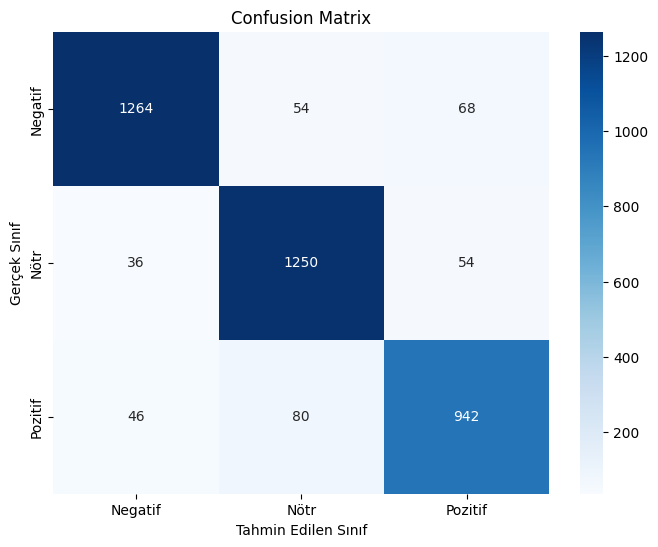

In [18]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negatif", "Nötr", "Pozitif"], yticklabels=["Negatif", "Nötr", "Pozitif"])
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Confusion Matrix")
plt.show()


In [20]:
print(classification_report(y_true_classes, y_pred_classes, target_names=["Negatif", "Nötr", "Pozitif"]))


              precision    recall  f1-score   support

     Negatif       0.94      0.91      0.93      1386
        Nötr       0.90      0.93      0.92      1340
     Pozitif       0.89      0.88      0.88      1068

    accuracy                           0.91      3794
   macro avg       0.91      0.91      0.91      3794
weighted avg       0.91      0.91      0.91      3794



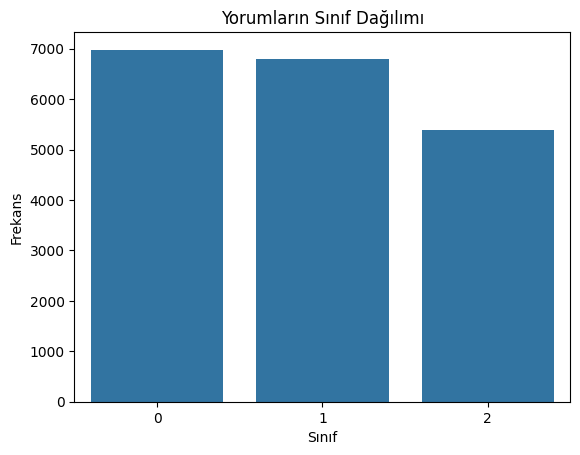

In [19]:
#3.YORUMLARIN DAĞILIMI GRAFİĞİ
sns.countplot(x='Durum', data=data)
plt.title('Yorumların Sınıf Dağılımı')
plt.xlabel('Sınıf')
plt.ylabel('Frekans')
plt.show()

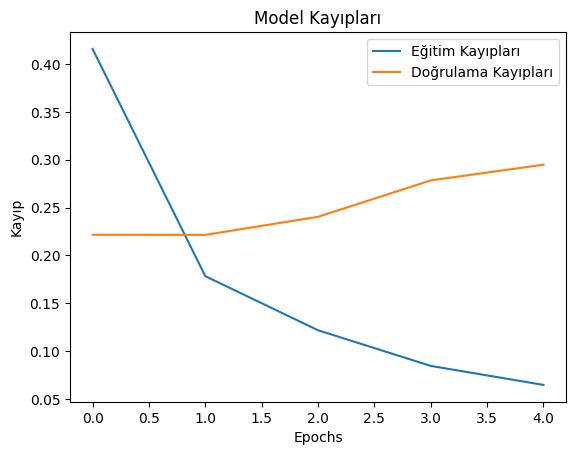

In [47]:
#2. Modelin Eğitim ve Doğrulama Kayıpları (Loss)
plt.plot(history.history['loss'], label='Eğitim Kayıpları')
plt.plot(history.history['val_loss'], label='Doğrulama Kayıpları')
plt.xlabel('Epochs')
plt.ylabel('Kayıp')
plt.legend()
plt.title('Model Kayıpları')
plt.show()

In [16]:


# ## 7. Model Performansının Değerlendirilmesi

# In[9]:

# Test veri setinde tahmin yapma
y_pred = model.predict(X_test_tfidf)
y_pred_classes = np.argmax(y_pred, axis=1)

# Performans metrikleri
print("Accuracy:", accuracy_score(y_test, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_test, y_pred_classes, target_names=["Negative", "Neutral", "Positive"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


NameError: name 'X_test_tfidf' is not defined